# The Traveling Tesla Salesman

http://mortada.net/the-traveling-tesla-salesman.html

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(15, 5)

In [2]:
from bs4 import BeautifulSoup
import re
import requests
import numpy as np
import pandas as pd

In [3]:
# get the list of superchargers in the US
url = 'http://www.teslamotors.com/findus/list/superchargers/United+States'
rv = requests.get(url)
content = rv.text

In [4]:
# get link to each supercharger, each page contains the supercharger's coordinates
sc_page_urls = re.findall('(/findus/location/supercharger/\w+)', content)

In [5]:
sc_page_urls[50:70]

['/findus/location/supercharger/truckeebrockwayroadsupercharger',
 '/findus/location/supercharger/truckeesupercharger',
 '/findus/location/supercharger/ukiahsupercharger',
 '/findus/location/supercharger/vacavillesupercharger',
 '/findus/location/supercharger/coloradospringssupercharger',
 '/findus/location/supercharger/denversupercharger',
 '/findus/location/supercharger/glenwoodspringssupercharger',
 '/findus/location/supercharger/grandjunctionsupercharger',
 '/findus/location/supercharger/limonsupercharger',
 '/findus/location/supercharger/parkmeadows',
 '/findus/location/supercharger/silverthornesupercharger',
 '/findus/location/supercharger/trinidadsupercharger',
 '/findus/location/supercharger/dariennorthsupercharger',
 '/findus/location/supercharger/dariensouthsupercharger',
 '/findus/location/supercharger/greenwichnorthsupercharger',
 '/findus/location/supercharger/greenwichsouthsupercharger',
 '/findus/location/supercharger/milfordnorthsupercharger',
 '/findus/location/superch

In [33]:
# get the cooridnates (latitude, longitude) for each supercharger
sc_names = []
sc_coors = {}
for sc_page_url in sc_page_urls[80:84]:
    url = 'http://www.teslamotors.com' + sc_page_url
    rv = requests.get(url)
    soup = BeautifulSoup(rv.text, "lxml")
    sc_name = soup.find('h1').text
    sc_names.append(sc_name)
    directions_link = soup.find('a', {'class': 'directions-link'})['href']
    lat, lng = directions_link.split('=')[-1].split(',')
    lat, lng = float(lat), float(lng)
    sc_coors[sc_name] = {'lat': lat, 'lng': lng}

In [34]:
sc_names

['St. Augustine Supercharger',
 'Tallahassee Supercharger',
 'Turkey Lake Supercharger',
 'West Palm Beach']

In [35]:
# sort the names
sc_names = sorted(sc_names)

In [36]:
coords = pd.DataFrame.from_dict(sc_coors).T.reindex(sc_names)
coords.head()

,lat,lng
St. Augustine Supercharger,29.924286,-81.416018
Tallahassee Supercharger,30.510908,-84.247841
Turkey Lake Supercharger,28.514873,-81.500189
West Palm Beach,26.778115,-80.109107


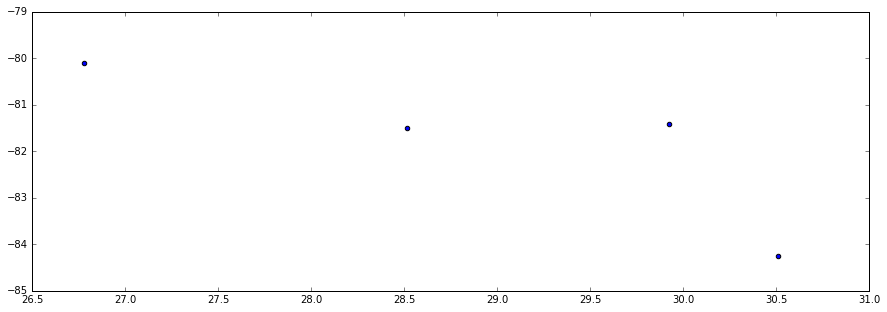

In [37]:
plt.scatter(x = 'lat', y = 'lng', data=coords)

In [22]:
def distance_on_earth(lat1, long1, lat2, long2, radius=6378.388):
    """
    Compute distance between two points on earth specified by latitude/longitude.
    The earth is assumed to be a perfect sphere of given radius. The radius defaults
    to 6378.388 kilometers. To convert to miles, divide by 1.60934
    
    Reference
    ---------
    Adopted from John D. Cook's blog post: 
    http://www.johndcook.com/blog/python_longitude_latitude/
    """
    # Convert latitude and longitude to spherical coordinates in radians.
    degrees_to_radians = np.pi / 180.0

    # phi = 90 - latitude
    phi1 = (90.0 - lat1) * degrees_to_radians
    phi2 = (90.0 - lat2) * degrees_to_radians

    # theta = longitude
    theta1 = long1 * degrees_to_radians
    theta2 = long2 * degrees_to_radians
         
    # Compute spherical distance from spherical coordinates.     
    cos = (np.sin(phi1) * np.sin(phi2)* np.cos(theta1 - theta2) + 
           np.cos(phi1) * np.cos(phi2))
    arc = np.arccos(cos)
    rv = arc * radius
    return rv

In [23]:

# get distances between all pairs
mile_in_km = 1.60934
distances = {}
for i in range(len(sc_names)):
    a = sc_names[i]
    distances[a] = {}
    for j in range(len(sc_names)):
        b = sc_names[j]
        if j == i:
            distances[a][b] = 0.
        elif j > i:
            distances[a][b] = distance_on_earth(coords.ix[a, 'lat'],
                                                coords.ix[a, 'lng'],
                                                coords.ix[b, 'lat'],
                                                coords.ix[b, 'lng'])
        else:
            distances[a][b] = distances[b][a]
distances = pd.DataFrame(distances) / mile_in_km

In [24]:
distances

,Brandon Supercharger,DeFuniak Springs Supercharger,Fort Drum Supercharger,Fort Myers Supercharger,Lake City Supercharger
Brandon Supercharger,0.000000,298.803089,94.808554,105.923802,156.487923
DeFuniak Springs Supercharger,298.803089,0.000000,385.702296,393.566489,208.317450
Fort Drum Supercharger,94.808554,385.702296,0.000000,97.373274,210.961352
Fort Myers Supercharger,105.923802,393.566489,97.373274,0.000000,261.361295
Lake City Supercharger,156.487923,208.317450,210.961352,261.361295,0.000000


In [38]:
sc_coors

{'St. Augustine Supercharger': {'lat': 29.924286, 'lng': -81.416018},
 'Tallahassee Supercharger': {'lat': 30.510908, 'lng': -84.247841},
 'Turkey Lake Supercharger': {'lat': 28.514873, 'lng': -81.500189},
 'West Palm Beach': {'lat': 26.7781155, 'lng': -80.1091072}}

In [39]:
# create input file for Concorde TSP solver
sc_id = 0
output = ''
for sc_name in sc_names:
    output += '%d %f %f\n' % (sc_id, sc_coors[sc_name]['lat'], sc_coors[sc_name]['lng'])
    sc_id += 1

header = """NAME : TTS
COMMENT : Traveling Tesla Salesman
TYPE : TSP
DIMENSION : %d
EDGE_WEIGHT_TYPE : GEO
NODE_COORD_SECTION
""" % sc_id

with open('sc.tsp', 'w') as output_file:
    output_file.write(header)
    output_file.write(output)

In [40]:
cat sc.tsp

NAME : TTS
COMMENT : Traveling Tesla Salesman
TYPE : TSP
DIMENSION : 4
EDGE_WEIGHT_TYPE : GEO
NODE_COORD_SECTION
0 29.924286 -81.416018
1 30.510908 -84.247841
2 28.514873 -81.500189
3 26.778115 -80.109107


In [41]:
!concorde sc.tsp

concorde sc.tsp
Host: Jianglongs-MacBook-Pro.local  Current process id: 1650
Using random seed 1462896570
Problem Name: TTS
Traveling Tesla Salesman
Problem Type: TSP
Number of Nodes: 4
Geographical Norm (CC_GEOGRAPHIC)
Optimal Solution: 1225.00
Total Running Time: 0.00 (seconds)


In [56]:
type(sc_coors['Los Angeles Supercharger']['lat'])

float

In [31]:
pwd

'/Users/jianglongli/Desktop/GA/portfolio'

In [36]:
# after running the Concorde executable, parse the output file
solution = []
f = open('sc.sol', 'r')
for line in f.readlines():
    tokens = line.split()
    solution += [int(c) for c in tokens]
f.close()

assert solution[0] == len(sc_names)
solution = solution[1:]  # first number is just the dimension
assert len(solution) == len(sc_names)

In [38]:
optimal_path = []
for solution_id in solution:
    optimal_path.append(sc_names[solution_id])

# connect back to the starting node
optimal_path.append(sc_names[solution[0]])
optimal_path = pd.Series(optimal_path)
optimal_path

0     Auburn Alabama Supercharger
1           Holbrook Supercharger
2          Flagstaff Supercharger
3            Kingman Supercharger
4       Cordes Lakes Supercharger
5            Buckeye Supercharger
6          Gila Bend Supercharger
7        Casa Grande Supercharger
8             Mobile Supercharger
9         Greenville Supercharger
10    Auburn Alabama Supercharger
dtype: object

In [40]:

# compute total distance in optimal path
total = 0
for i in range(len(optimal_path) - 1):
    total += distances.ix[optimal_path[i], optimal_path[i + 1]]
total

3537.0782638849332